In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from itertools import combinations
from collections import Counter
from zipfile import ZipFile
import os
from networkx.algorithms.community import girvan_newman
import json
import requests
import re
import matplotlib.patches as mpatches
import itertools
import matplotlib.cm as cm
from pprint import pprint
import math
import pyLDAvis.gensim
import pickle 
import pyLDAvis
from tqdm import tqdm
import gensim
from gensim import corpora
from wordcloud import WordCloud

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
pd.options.mode.chained_assignment = None  # default='warn'

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mydun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mydun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Reusable variables
seed = 33
d_color = "#4152ec"
colors = ['#292929', '#768695', d_color, '#50dcff', '#ffa30e', '#ffe72f', '#f43131', '#ff9ad2', '#2ca02c', '#a8ee72', '#795133', '#c98d66']

In [4]:
# used csv files, linking it with their source zip files
csv_to_zip_source = {
    "Netflix_Dataset_Movie.csv": "zip_sources/Netflix_Dataset_Movie.csv.zip",
    "Netflix_Dataset_Rating.csv": "zip_sources/Netflix_Dataset_Rating.csv.zip",
    "tmdb_5000_credits.csv": "zip_sources/tmdb.zip",
    "tmdb_5000_movies.csv": "zip_sources/tmdb.zip"
}

csv_file_names = list(csv_to_zip_source.keys())

# common data directory path
data_dir = "./data"

# if directory does not exist, create it
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

# check if all .csv can be found in data directory, if not we extract it from corresponding zip source
for csv_file_name in csv_file_names:
    if not os.path.exists(f"{data_dir}/{csv_file_name}"):
        # if it is not found
        zip_source_file_name = csv_to_zip_source[csv_file_name]
        print(f"❗'{csv_file_name}' does not exist in the '{data_dir}' directory, extracting it from zip file '{zip_source_file_name}'...")
        with ZipFile(zip_source_file_name, 'r') as zip:
            zip.extract(csv_file_name, path=data_dir)
            print(f"Done extracting {csv_file_name} from {zip_source_file_name}")
    else:
        # csv exists and found, let user know
        print(f"'{data_dir}/{csv_file_name}' exists ✅")
    print("---")

'./data/Netflix_Dataset_Movie.csv' exists ✅
---
'./data/Netflix_Dataset_Rating.csv' exists ✅
---
'./data/tmdb_5000_credits.csv' exists ✅
---
'./data/tmdb_5000_movies.csv' exists ✅
---


In [5]:
movies = pd.read_csv(f"{data_dir}/Netflix_Dataset_Movie.csv")
ratings = pd.read_csv(f"{data_dir}/Netflix_Dataset_Rating.csv")
credits = pd.read_csv(f"{data_dir}/tmdb_5000_credits.csv")
tmdb_movies = pd.read_csv(f"{data_dir}/tmdb_5000_movies.csv")

In [7]:
movies_subset = movies[movies.Year >= 2000]
df_movies_subset = movies_subset[movies_subset.Name.isin(credits.title)] #movies that are in credits
df_tmdb = tmdb_movies[tmdb_movies.title.isin(df_movies_subset.Name)].reset_index() #movies that are also in the other movie data set
df_credits = credits[credits.movie_id.isin(df_tmdb.id)]#this line is not needed

---
# **Movie network**
---
- **Nodes**: Movies
- **Edges**: Two movies are connected if they have a common actor in their top 5 staring actors.

## **Network**

In [8]:
G_movies = nx.Graph()

# Iterate over each row in the credits dataframe
for index, row in df_credits.iterrows():
    cast = json.loads(row['cast']) # Parse the cast column (=JSON string)
    
    # Get names of the first 10 actors
    actors = [actor['name'] for actor in cast[:5]]
    G_movies.add_node(row['title'], actors=actors)

# Iterate over all pairs of movies
for movie1, movie2 in combinations(G_movies.nodes, 2):
    # Actors for each movie
    actors1 = G_movies.nodes[movie1]['actors']
    actors2 = G_movies.nodes[movie2]['actors']
    
    # Number of common actors
    common_actors = len(set(actors1) & set(actors2))
    
    # If they have at least x common actors, add an edge between them
    if common_actors >= 1:
        G_movies.add_edge(movie1, movie2)


In [9]:
# Largest connected component
largest_cc = max(nx.connected_components(G_movies), key=len)
G_movies_lcc = G_movies.subgraph(largest_cc)

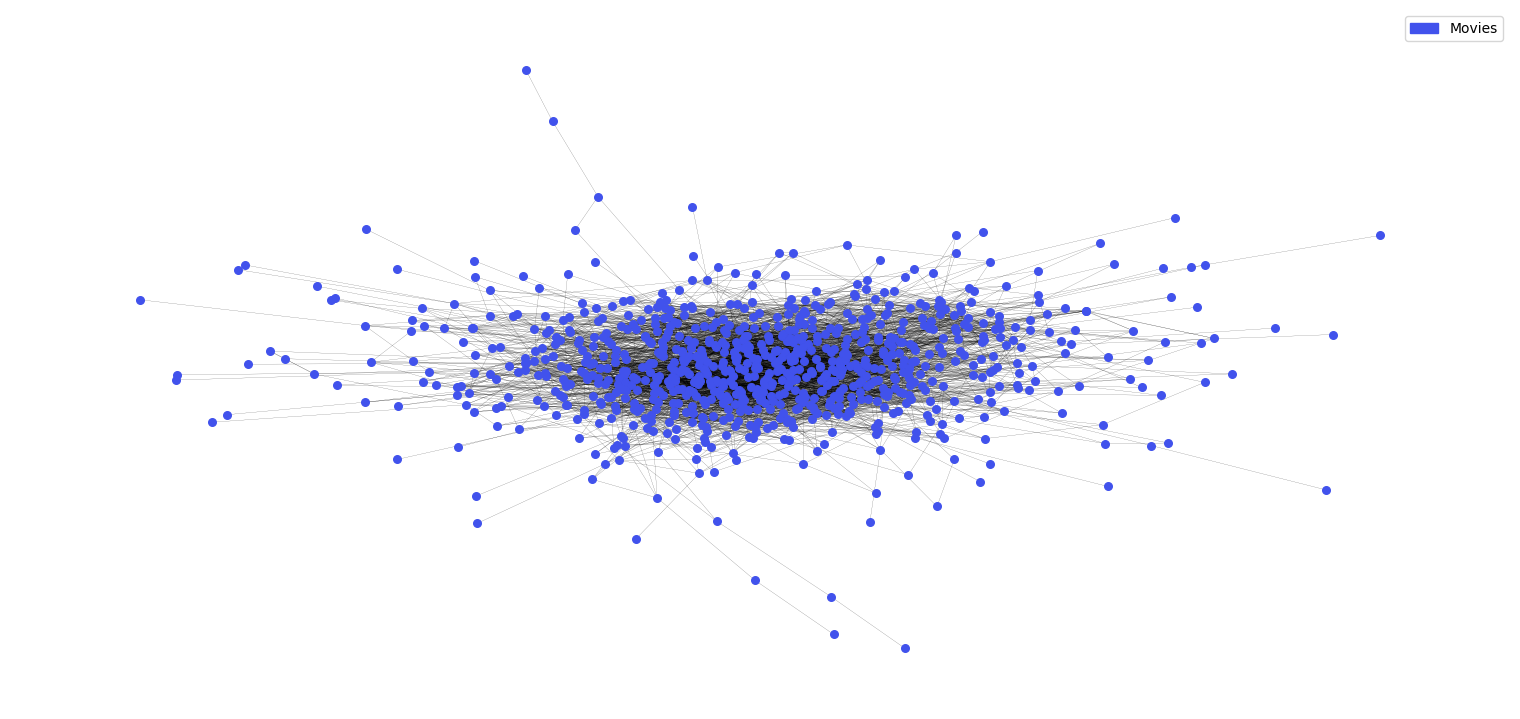

In [10]:
# Layout
plt.figure(figsize=(15, 7))
pos = nx.spring_layout(G_movies_lcc)

# Draw network
nx.draw(G_movies_lcc, pos, node_color=d_color, edge_color='black', with_labels=False, node_size=30, width=0.1)

# Legend
movies_patch = mpatches.Patch(color=d_color, label='Movies')
plt.legend(handles=[movies_patch])

plt.show()

In [11]:
n, m = len(G_movies.nodes()), len(G_movies.edges())
print('Nb nodes: n =', n)
print('Nb edges: m =', m)

Nb nodes: n = 936
Nb edges: m = 4586


## **Communities**

In [12]:
# comparing with NetworkX
nx_communities = nx.algorithms.centrality.edge_betweenness_centrality(G_movies)

nx_girvan_newman = nx.algorithms.community.centrality.girvan_newman(G_movies)

nx_best_community = tuple(sorted(c) for c in next(nx_girvan_newman))
print('Comparing best communities:')
print('\t- NetworkX:', nx_best_community)

nx_modularity_G = nx.algorithms.community.quality.modularity(G_movies, nx_best_community)
print('\nComparing Modularity:')
print('\t- NetworkX:', nx_modularity_G)

Comparing best communities:
	- NetworkX: (['102 Dalmatians', '11:14', '13 Going on 30', '2 Fast 2 Furious', '21 Grams', '25th Hour', '28 Days', '28 Days Later', '3 Strikes', '3000 Miles to Graceland', '40 Days and 40 Nights', '50 First Dates', '8 Mile', '8 Women', 'A Beautiful Mind', 'A Cinderella Story', 'A Guy Thing', 'A Home at the End of the World', "A Knight's Tale", 'A Lot Like Love', 'A Man Apart', 'A Mighty Wind', 'A Very Long Engagement', 'A Walk to Remember', 'A.I. Artificial Intelligence', 'Abandon', 'Abandoned', 'Aberdeen', 'About Schmidt', 'About a Boy', 'After the Sunset', 'Against the Ropes', 'Agent Cody Banks', 'Agent Cody Banks 2: Destination London', 'Alfie', 'Ali', 'Alive', 'All About the Benjamins', 'All or Nothing', 'All the Pretty Horses', 'All the Real Girls', 'Almost Famous', 'Alone in the Dark', 'Along Came Polly', 'Along Came a Spider', 'Amen.', "America's Sweethearts", 'American Desi', 'American Outlaws', 'American Pie 2', 'American Psycho', 'American Splendo

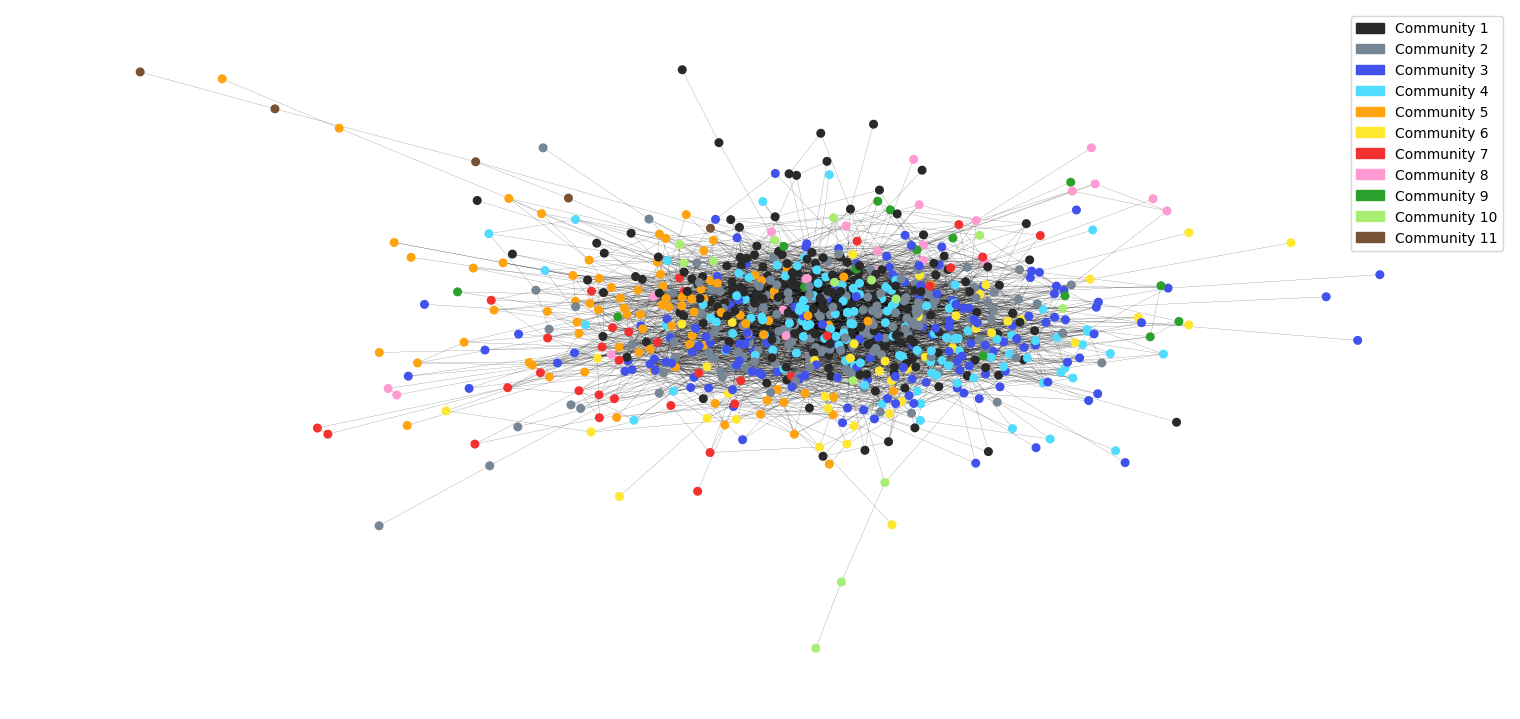

In [13]:
# Communities
communities = nx.algorithms.community.greedy_modularity_communities(G_movies_lcc)

# Plot
plt.figure(figsize=(15, 7))
pos = nx.spring_layout(G_movies_lcc)
color_map = {node: colors[i % len(colors)] for i, community in enumerate(communities) for node in community}
nx.draw(G_movies_lcc, pos, node_color=[color_map[node] for node in G_movies_lcc.nodes], edge_color='black', with_labels=False, node_size=30, width=0.1)
patches = [mpatches.Patch(color=colors[i % len(colors)], label=f'Community {i+1}') for i in range(len(communities))]
plt.legend(handles=patches)
plt.show()


In [14]:
# Number of Movies in Each Community
for i, community in enumerate(communities, start=1):
    print(f'Community {i}: \t {len(community)} movies')

Community 1: 	 183 movies
Community 2: 	 164 movies
Community 3: 	 154 movies
Community 4: 	 126 movies
Community 5: 	 90 movies
Community 6: 	 44 movies
Community 7: 	 33 movies
Community 8: 	 23 movies
Community 9: 	 15 movies
Community 10: 	 14 movies
Community 11: 	 5 movies


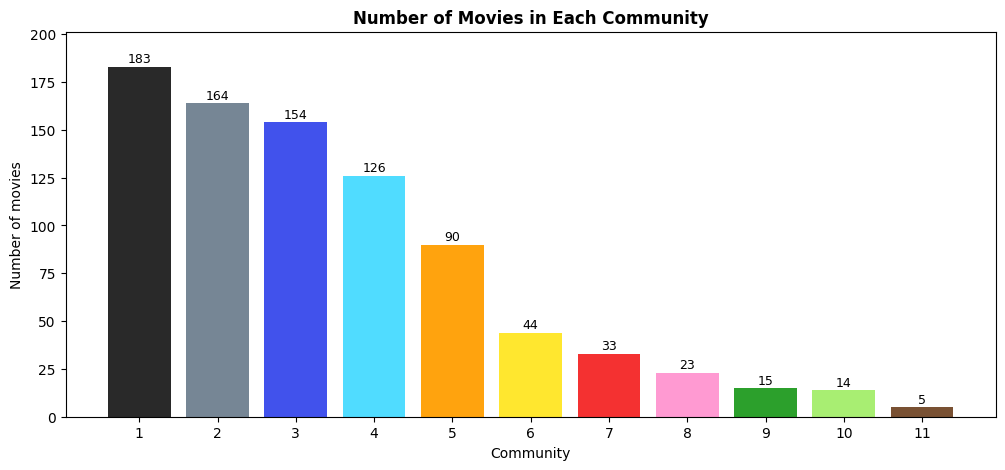

In [15]:
# Number of movies in each community
num_movies = [len(community) for community in communities]

# Histogram
plt.figure(figsize=(12, 5))
bars = plt.bar(range(1, len(communities) + 1), num_movies, color=[colors[i % len(colors)] for i in range(len(communities))])
plt.xticks(range(1, len(communities) + 1))
plt.ylim(0, max(num_movies) + (max(num_movies)/10))
plt.xlabel('Community')
plt.ylabel('Number of movies')
plt.title('Number of Movies in Each Community', fontweight='bold')

# Add the precise number of movies above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom', fontsize=9)

plt.show()


In [16]:
# Number of Movies in Each Community and their titles
for i, community in enumerate(communities, start=1):
    print(f'Community {i}:')
    for movie in community:
        print(f'\t- {movie}')
    print('\n')


Community 1:
	- Bend It Like Beckham
	- The Incredible Hulk
	- Dirty Pretty Things
	- Soul Survivors
	- The Next Best Thing
	- Planet of the Apes
	- Spider-Man
	- Jimmy Neutron: Boy Genius
	- The Yards
	- The Glass House
	- Requiem for a Dream
	- Veronica Guerin
	- Gossip
	- Traffic
	- American Psycho
	- The Great Gatsby
	- Hotel Rwanda
	- Joe Somebody
	- Carnage
	- The Flintstones in Viva Rock Vegas
	- 40 Days and 40 Nights
	- Big Trouble
	- Pollock
	- What Women Want
	- The Quiet American
	- Crazy/Beautiful
	- Old School
	- Hollow Man
	- The Hunted
	- Catwoman
	- Elf
	- Battlefield Earth
	- Panic Room
	- Red Planet
	- Legally Blonde
	- Gladiator
	- Wonder Boys
	- The Importance of Being Earnest
	- Swept Away
	- The Ring Two
	- Seabiscuit
	- Swimming Pool
	- Domestic Disturbance
	- Catch That Kid
	- 28 Days
	- Hearts in Atlantis
	- House of Sand and Fog
	- The Road to El Dorado
	- The Santa Clause 2
	- Hamlet
	- Abandon
	- The Punisher
	- The Country Bears
	- Wrong Turn
	- Be Cool
	- 

## **Degrees**
- A high degree count for a movie means that the movie shares a significant number of actors with many other movies. This means that many of the actors in the movie have also acted in a large number of other movies in the network. This could indicate that the movie has a well-known or versatile cast.

In [24]:
# Both old and new users
degrees = G_movies.degree()
top_10_movies_degree = sorted(degrees, key=lambda x: x[1], reverse=True)[:10]
for movie, degree in top_10_movies_degree:
    print(f'{movie}: {degree}')

Shark Tale: 33
The Italian Job: 29
Men of Honor: 28
Nurse Betty: 28
Pearl Harbor: 27
Vanilla Sky: 27
Meet the Parents: 27
Batman Begins: 26
High Crimes: 26
Charlie's Angels: Full Throttle: 25


## **Betweenness centrality**
- Betweenness centrality is a measure of a node’s centrality in a network. It is equal to the number of shortest paths from all vertices to all others that pass through that node. A higher betweenness centrality generally means that a node is more central in the network.
- Maybe use for new users (no movies seen yet). The movies with high betweenness centrality would be good for new users as the movies are connected to many other movies in the network through shared actors. 

In [18]:
# Use for new users maybe
centrality = nx.betweenness_centrality(G_movies)
top_10_movies_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for movie, centrality in top_10_movies_centrality:
    print(f'{movie}: {centrality}')

The Italian Job: 0.01295773761848073
Vanilla Sky: 0.011669802477575625
High Crimes: 0.011581943660039548
Shark Tale: 0.009823422719670495
Nurse Betty: 0.009812055980097987
Pearl Harbor: 0.009391112208518262
Batman Begins: 0.008989144223062975
Envy: 0.008896221618697768
Men of Honor: 0.008793986081146139
The Yards: 0.008785624073374017


## **Recommend movies based on communites**
- Sort these movies based on number of common actors

In [25]:
# Should have seen at least one movie. Recommend based on latest seen movie.
def top_10_movies_common_actors(movie_title, G_movies):
    given_movie_actors = set(G_movies.nodes[movie_title]['actors'])

    # Number of common actors for each movie
    common_actors = {movie: len(given_movie_actors & set(G_movies.nodes[movie]['actors'])) for movie in G_movies.nodes if movie != movie_title}
    common_actors = {movie: actors for movie, actors in common_actors.items() if actors > 0}
    if not common_actors:
        print(f'No movies found with common actors to "{movie_title}".')
        return []
    sorted_movies = sorted(common_actors.items(), key=lambda x: x[1], reverse=True)
    top_movies = sorted_movies

    return top_movies

In [26]:
def print_movie_community(movie_title, communities):
    for i, community in enumerate(communities, start=1):
        if movie_title in community:
            print(f'"{movie_title}" is in Community {i}. These are the top 10 recommended movies with common actors:')
            sorted_movies = top_10_movies_common_actors(movie_title, G_movies)
            sorted_movies = [movie for movie in sorted_movies if movie[0] in community]
            for movie, common_actors in sorted_movies:
                print(f'\t- {movie}: {common_actors}')
            if len(sorted_movies) < 10:
                print(f'\nNote: There are only {len(sorted_movies)} movies with common actors to "{movie_title}".')
            break
    else:
        print(f'"{movie_title}" is not found in any community.')


In [28]:
print_movie_community("The Italian Job", communities)

"The Italian Job" is in Community 4. These are the top 10 recommended movies with common actors:
	- Red Dragon: 1
	- The Score: 1
	- Death to Smoochy: 1
	- Sweet November: 1
	- Reindeer Games: 1
	- Men of Honor: 1
	- Keeping the Faith: 1
	- Monster: 1
	- 25th Hour: 1

Note: There are only 9 movies with common actors to "The Italian Job".


In [35]:
def get_movie_community_df(movie_title):
    # Find community of the given movie
    for community in communities:
        if movie_title in community:
            df_tmdb_community = df_tmdb[df_tmdb['title'].isin(community)] # Filter dataframe so it only includes the movies in the community of the input movie           
            return df_tmdb_community

    print(f'"{movie_title}" is not found in any community.')
    return pd.DataFrame()

df_tmdb_new = get_movie_community_df("The Italian Job")
df_tmdb_new

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
5,110,140000000,"[{""id"": 36, ""name"": ""History""}, {""id"": 10749, ...",NaN,676,"[{""id"": 428, ""name"": ""nurse""}, {""id"": 1627, ""n...",en,Pearl Harbor,The lifelong friendship between Rafe McCawley ...,34.206690,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2001-05-21,449220945,183.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,It takes a moment to change history. It takes ...,Pearl Harbor,6.6,1791
19,194,127500000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",NaN,10567,"[{""id"": 843, ""name"": ""cataclysm""}, {""id"": 1423...",en,Dinosaur,An orphaned dinosaur raised by lemurs joins an...,26.548594,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2000-05-19,354248063,82.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,You have never seen anything like this.,Dinosaur,6.2,542
36,272,90000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,24113,"[{""id"": 2301, ""name"": ""architect""}, {""id"": 345...",en,Town & Country,Porter Stoddard is a well-known New York archi...,1.004579,...,[],2001-04-27,10372291,104.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,There's no such thing as a small affair.,Town & Country,3.7,16
56,339,92000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://disney.go.com/disneyvideos/animatedfilm...,9806,"[{""id"": 1308, ""name"": ""secret identity""}, {""id...",en,The Incredibles,Bob Parr has given up his superhero days to lo...,77.817571,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2004-11-05,631442092,115.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,"No gut, no glory",The Incredibles,7.4,5152
79,412,60000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...",NaN,9341,"[{""id"": 5178, ""name"": ""magnetic field""}, {""id""...",en,The Core,Geophysicist Dr. Josh Keyes discovers that an ...,29.211255,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-03-28,74208267,136.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Earth has a deadline.,The Core,5.4,516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,4190,500000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 27, ""name...",NaN,10894,"[{""id"": 2467, ""name"": ""difficult childhood""}, ...",en,May,Psychological horror about a lonely young woma...,8.650779,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2002-01-13,150277,93.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Be Careful... She Just Might Take Your Heart.,May,6.3,152
878,4291,1200000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 9648, ""n...",NaN,176,"[{""id"": 1366, ""name"": ""shotgun""}, {""id"": 13000...",en,Saw,Obsessed with teaching his victims the value o...,63.655973,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2004-10-01,103911669,103.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Live or die. Make your choice.,Saw,7.2,2184
906,4531,0,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 18, ""name...",NaN,30246,"[{""id"": 187056, ""name"": ""woman director""}]",en,Civil Brand,Forced to work under slave-like conditions in ...,0.665512,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-08-29,0,95.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,Civil Brand,5.3,4
927,4703,150000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",NaN,39141,"[{""id"": 10183, ""name"": ""independent film""}]",en,Tadpole,"Beautiful, sophisticated women are all over Os...",8.570328,...,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2002-11-01,2891288,78.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Every

---
# **Topic Modelling**
---